# Bayesian Neural Network
In this tutorial, ...

# Imports

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import Image

# Initialization

## Set random seed

In [ ]:
RANDOM_SEED = 2021
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED) 

## Set device

In [ ]:
# Use the GPU provided by Google Colab if run time is GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Regression

## Generate artificial dataset

In [ ]:
def load_dataset(n=150):
    '''
    Generate an artificial dataset in which noise dependent on X
    Args:
      n: number of artificial points
    '''
    np.random.seed(43)

    w0 = 0.2
    b0 = 1
    x_range = [-20, 60]

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    # noise dependent on X
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return x[:, None], y[:, None]

X, y = load_dataset()
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (150, 1)
y shape: (150, 1)


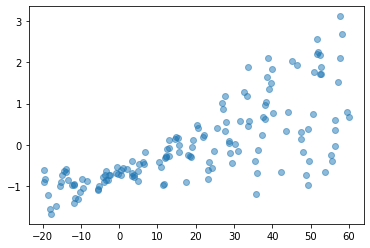

In [ ]:
plt.scatter(X, y, alpha=0.5);

## Maximum Likelihood Estimation (MLE)
Maximum likelihood estimation is a method that determines values for the parameters of a model. The parameter values are found such that they maximise the likelihood that the process described by the model produced the data that were actually observed.
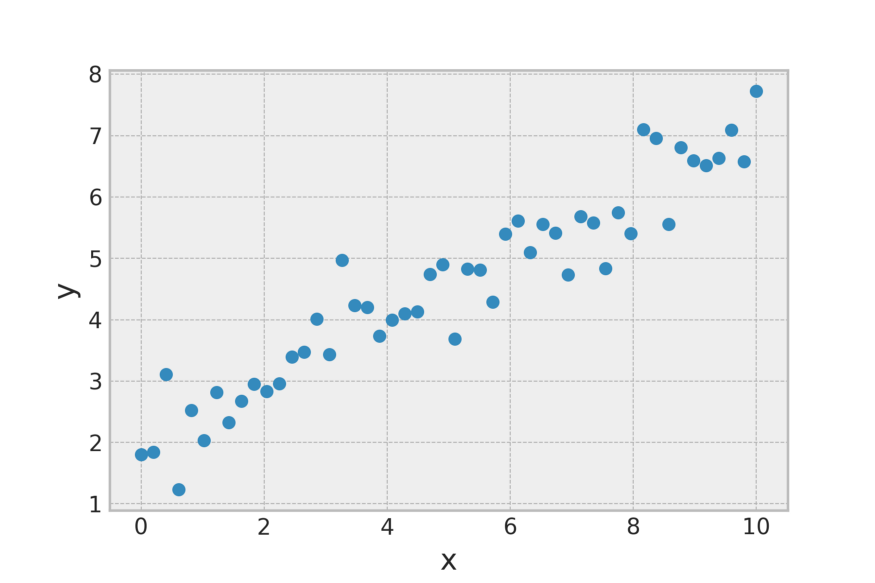

Let's say we want to model the data above which clearly has a linear relationship. So we'll model it with an equation of a line.
\begin{align}
y = \theta_{1}x + \theta_{0}
\end{align}
However, if the underlying relationship is linear, how do we account for the deviations we're seeing? Therefore, we're going to model the errors as being drawn from a Gaussian distribution with mean $0$ and variance $\sigma^{2}$
\begin{align}
\epsilon \sim N(0, \sigma^{2})\\
y = \theta_{1}x + \theta_{0} + \epsilon
\end{align}


### Derivation of MLE for regression
With the intuition above, we can start computing the **log likelihood**, which is the probability of the data given the parameters of the model (in this case $\theta$, which consists of $\theta_{1}$ and $\theta_{0}$). \\

The log likehood of our model is \\
\begin{align}
logp(y|X, \theta) = \sum^{N}_{i=1}logp(y_{i}|x_{i},\theta)
\end{align}
, where N is the size of our training set. \\
But since the noise $\epsilon$ is Gaussian, the likelihood is just
\begin{align}
logp(y|X, \theta) &= \sum_{i=1}^{N} logN(y_{i};\theta_{1}x+\theta_{0}, \sigma^{2})\\
&=\sum_{i=1}^{N} log\frac{1}{\sqrt{2\pi\sigma^{2}}}exp(-\frac{(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}}{2\sigma^{2}})\\
&= -\frac{N}{2}log2\pi\sigma^2 - \sum_{i=1}^{N}\frac{(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}}{2\sigma^{2}}
\end{align}
Now our objective is to find the $\theta$ that maximizes $logp(y|X, \theta)$. We can consider $\sigma$ as constant in this case thus simplifying our objective funtion further:
\begin{align}
\theta_{MLE} &= \underset{\theta}{\arg\max}-\sum_{i=1}^{N}(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}\\
&= \underset{\theta}{\arg\min}\sum_{i=1}^{N}(y_{i}-(\theta_{1}x_{i}+\theta_{0}))^{2}\\
&=\underset{\theta}{\arg\min}MSE_{train}
\end{align}
This is why whenever we are minimizing MSE we're acutally maximizing the log likelihood!










In [ ]:
Image(url='https://miro.medium.com/max/1200/1*jxZFpWtCbD4jHPV0DdDuMA.gif')

From the [GIF](https://towardsdatascience.com/maximum-likelihood-estimation-984af2dcfcac) above, we see that as the parameter starts to model the data better and better, the log likelihood increases. The goal of MLE is to find the parameter that maximizes the log likelihood. <br>

### Coding Exercise: Implement MLE to fit the model
We're using 20 hidden units + 1 bias unit instead of 1 hidden unit + 1 bias unit in the example above in order for the model to learn a more complex function

In [ ]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = ((y_pred - y)**2).mean()
    loss.backward()
    optim.step()

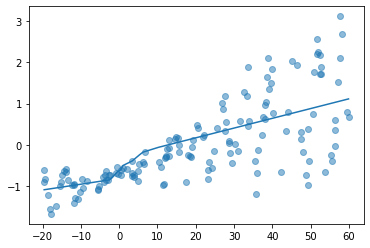

In [ ]:
plt.scatter(X, y, alpha=0.5)
plt.plot(X.detach().numpy(), m(X).detach().numpy(), alpha=1);

# Classification (Bonus)

## Softmax Activation Function
The softmax activation function is often placed at the output layer of a neural network. It’s commonly used in multi-class learning problems where a set of features can be related to one-of-K classes. For example, in the CIFAR-10 image classification problem, given a set of pixels as input, we need to classify if a particular sample belongs to one-of-ten available classes: i.e., cat, dog, horse, etc.
Its equation is simple, we just have to compute for the normalized exponential function of all the units in the layer. In such case,
\begin{align}
S(y_{i}) = \frac{e^{y_{i}}}{\sum_{i}e^{y_{i}}}
\end{align}
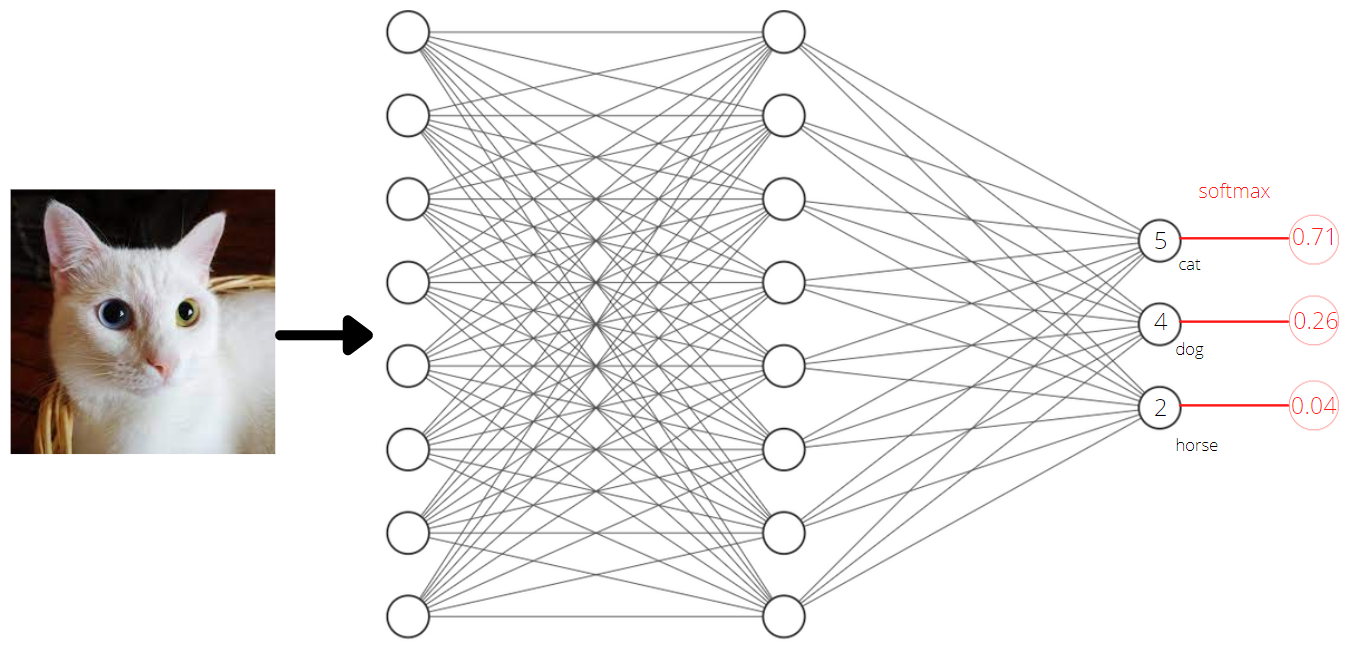

### Coding Exercise 1: Implement softmax activation function
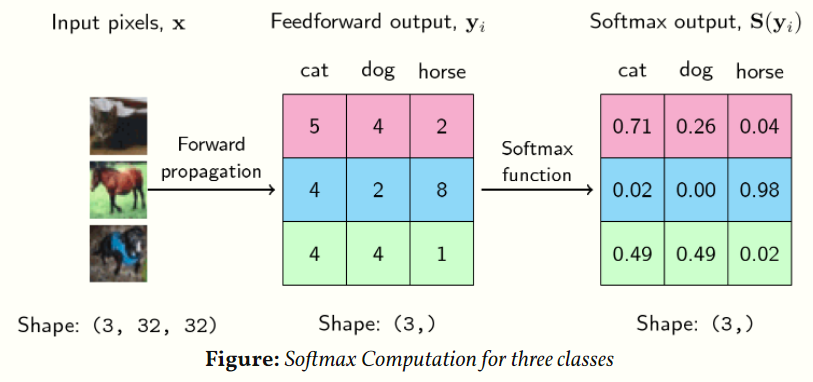<br>[Image source](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>

In [ ]:
# cat
forward_output = np.array([[5, 4, 2]], dtype=np.float)
target = np.array([0])
print(F.softmax(torch.tensor(forward_output), dim=-1))

# horse
forward_output = np.array([[4, 2, 8]], dtype=np.float)
target = np.array([2])
print(F.softmax(torch.tensor(forward_output), dim=-1))

# dog
forward_output = np.array([[4, 4, 1]], dtype=np.float)
target = np.array([1])
print(F.softmax(torch.tensor(forward_output), dim=-1))

tensor([[0.7054, 0.2595, 0.0351]], dtype=torch.float64)
tensor([[0.0179, 0.0024, 0.9796]], dtype=torch.float64)
tensor([[0.4879, 0.4879, 0.0243]], dtype=torch.float64)


## Negative Log Likelihood (NLL)
The negative log-likelihood becomes unhappy at smaller values, where it can reach infinite unhappiness (that’s too sad), and becomes less unhappy at larger values. Because we are summing the loss function to all the correct classes, what’s actually happening is that whenever the network assigns high confidence at the correct class, the unhappiness is low, but when the network assigns low confidence at the correct class, the unhappiness is high.
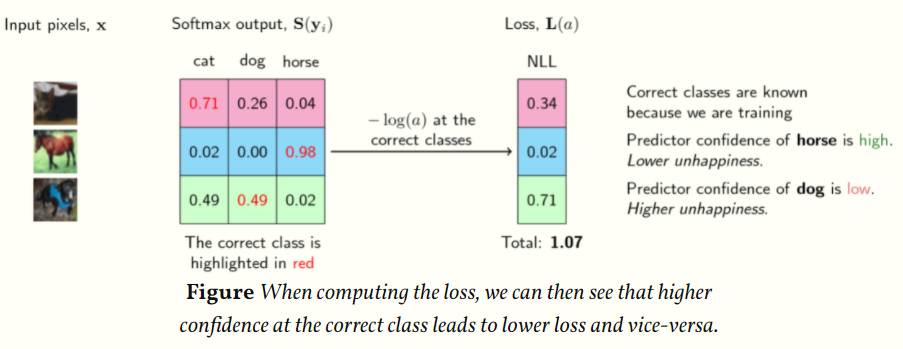<br>[Image source](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>
We're going to walk through the example above to see how NLL is calulated of multi-class classificaiton.
\begin{align}
NLL = \sum_{\color{red}\alpha \in S(y_{i})}^{} -log(\color{red}\alpha)\\
cat: \alpha = -log(0.71) \approx 0.34\\ 
horse: \alpha = -log(0.98) \approx 0.02\\
dog: \alpha = -log(0.49) \approx 0.71\\
NLL \approx 0.34 + 0.02 + 0.71 = 1.07
\end{align}


### Coding Exercise 2: Implement NLL

In [ ]:
# cat
forward_output = np.array([[5, 4, 2]], dtype=np.float)
target = np.array([0])
nll_cat = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_cat)

# horse
forward_output = np.array([[4, 2, 8]], dtype=np.float)
target = np.array([2])
nll_horse = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_horse)

# dog
forward_output = np.array([[4, 4, 1]], dtype=np.float)
target = np.array([1])
nll_dog = F.nll_loss(F.log_softmax(torch.tensor(forward_output), dim=-1), torch.tensor(target))
print(nll_dog)

NLL = nll_cat + nll_horse + nll_dog
print(NLL)

tensor(0.3490, dtype=torch.float64)
tensor(0.0206, dtype=torch.float64)
tensor(0.7177, dtype=torch.float64)
tensor(1.0873, dtype=torch.float64)


## Maximum Likelihood Estimation (MLE)
Maximum likelihood estimation is a method that determines values for the parameters of a model. The parameter values are found such that they maximise the likelihood that the process described by the model produced the data that were actually observed.

# References
[Miranda, Understanding softmax and the negative log-likelihood](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)<br>
[Fleshman, Maximum Likelihood Estimation](https://towardsdatascience.com/maximum-likelihood-estimation-984af2dcfcac)